<a href="https://colab.research.google.com/github/AnovaYoung/AI-System-for-Image-Restoration-and-Enhancement/blob/Modeling/re_workedmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DOWNLOAD CIFAR-100

In [1]:
from torchvision.datasets import CIFAR100
from torchvision.transforms import ToTensor, Resize
from PIL import Image
import os

# Download CIFAR-100 dataset
data = CIFAR100(root='./data', train=True, download=True)

# Define paths
high_res_dir = './cifar100_high_res'
os.makedirs(high_res_dir, exist_ok=True)

# Resize and save as high-resolution
for idx, (image, label) in enumerate(data):
    high_res_image = image.resize((128, 128), Image.BICUBIC)  # Upscale to 128x128
    high_res_image.save(os.path.join(high_res_dir, f'image_{idx:05d}.png'))

100%|██████████| 169M/169M [00:12<00:00, 13.1MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data


CREATE LOW-RES PAIRS

In [2]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import pickle


# Paths
cifar_data_dir = "/content/data/cifar-100-python"
output_dir = "/content/cifar_super_resolution"
os.makedirs(output_dir, exist_ok=True)

# Scaling factors
downscale_factor = 4
original_size = 32
downscaled_size = original_size // downscale_factor

# Load CIFAR-100 data
def load_cifar_data(file_path):
    with open(file_path, 'rb') as f:
        data_dict = pickle.load(f, encoding='bytes')
    images = data_dict[b'data']
    labels = data_dict[b'fine_labels']
    # Reshape to (num_images, 32, 32, 3)
    images = images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    return images, labels

# Downscale and save images
def process_images(images, save_dir, prefix):
    hr_dir = os.path.join(save_dir, f"{prefix}_hr")
    lr_dir = os.path.join(save_dir, f"{prefix}_lr")
    os.makedirs(hr_dir, exist_ok=True)
    os.makedirs(lr_dir, exist_ok=True)

    for idx, img in enumerate(tqdm(images, desc=f"Processing {prefix} images")):
        # Convert to PIL Image
        img_hr = Image.fromarray(img)
        # Downscale
        img_lr = img_hr.resize((downscaled_size, downscaled_size), Image.BICUBIC)
        # Save as .npy
        np.save(os.path.join(hr_dir, f"img_{idx:05d}_hr.npy"), np.array(img_hr, dtype=np.float32) / 255.0)
        np.save(os.path.join(lr_dir, f"img_{idx:05d}_lr.npy"), np.array(img_lr, dtype=np.float32) / 255.0)

# Load and process train data
train_images, train_labels = load_cifar_data(os.path.join(cifar_data_dir, "train"))
process_images(train_images, output_dir, "train")

# Load and process test data
test_images, test_labels = load_cifar_data(os.path.join(cifar_data_dir, "test"))
process_images(test_images, output_dir, "test")

print("High-resolution and low-resolution images created and saved!")


Processing test images: 100%|██████████| 10000/10000 [00:03<00:00, 2535.32it/s]

High-resolution and low-resolution images created and saved!


In [3]:
paths = {
    "Test HR": "/content/cifar_super_resolution/test_hr",
    "Test LR": "/content/cifar_super_resolution/test_lr",
    "Train HR": "/content/cifar_super_resolution/train_hr",
    "Train LR": "/content/cifar_super_resolution/train_lr",
}

# Function to check file count and display a few filenames
def check_folder_content(folder_path, name):
    if os.path.exists(folder_path):
        files = os.listdir(folder_path)
        print(f"{name}: {len(files)} files")
        print(f"Sample files from {name}: {files[:5]}")
    else:
        print(f"{name} folder does not exist!")

# Check each path
for name, path in paths.items():
    check_folder_content(path, name)


Test HR: 10000 files
Sample files from Test HR: ['img_03897_hr.npy', 'img_04356_hr.npy', 'img_08863_hr.npy', 'img_06219_hr.npy', 'img_01238_hr.npy']
Test LR: 10000 files
Sample files from Test LR: ['img_01529_lr.npy', 'img_03055_lr.npy', 'img_03478_lr.npy', 'img_04561_lr.npy', 'img_05337_lr.npy']
Train HR: 50000 files
Sample files from Train HR: ['img_16114_hr.npy', 'img_03897_hr.npy', 'img_18820_hr.npy', 'img_19410_hr.npy', 'img_36025_hr.npy']
Train LR: 50000 files
Sample files from Train LR: ['img_01529_lr.npy', 'img_33853_lr.npy', 'img_46371_lr.npy', 'img_43867_lr.npy', 'img_03055_lr.npy']


In [4]:
import os
import pickle
import numpy as np
from PIL import Image
from tqdm import tqdm

# Paths
cifar_data_dir = "/content/data/cifar-100-python"
output_dir = "/content/cifar_super_resolution"
os.makedirs(output_dir, exist_ok=True)

# Function to process CIFAR-100 data
def process_cifar_data(file_path, lr_dir, hr_dir):
    with open(file_path, "rb") as f:
        data_dict = pickle.load(f, encoding="bytes")
    images = data_dict[b"data"]
    filenames = data_dict[b"filenames"]

    # Reshape images and save
    for i in tqdm(range(len(images)), desc=f"Processing {file_path}"):
        img = images[i].reshape(3, 32, 32).transpose(1, 2, 0)  # Convert to HWC
        hr_path = os.path.join(hr_dir, f"img_{i:05d}_hr.npy")
        lr_path = os.path.join(lr_dir, f"img_{i:05d}_lr.npy")

        # Save HR image
        hr_data = (img / 255.0) * 2 - 1  # Normalize [-1, 1]
        np.save(hr_path, hr_data)

        # Downscale and save LR image
        lr_img = Image.fromarray(img).resize((8, 8), Image.BICUBIC).resize((32, 32), Image.BICUBIC)
        lr_data = (np.asarray(lr_img, dtype=np.float32) / 255.0) * 2 - 1  # Normalize [-1, 1]
        np.save(lr_path, lr_data)

# Create directories
train_lr_dir = os.path.join(output_dir, "train_lr")
train_hr_dir = os.path.join(output_dir, "train_hr")
test_lr_dir = os.path.join(output_dir, "test_lr")
test_hr_dir = os.path.join(output_dir, "test_hr")
os.makedirs(train_lr_dir, exist_ok=True)
os.makedirs(train_hr_dir, exist_ok=True)
os.makedirs(test_lr_dir, exist_ok=True)
os.makedirs(test_hr_dir, exist_ok=True)

# Process train and test data
process_cifar_data(os.path.join(cifar_data_dir, "train"), train_lr_dir, train_hr_dir)
process_cifar_data(os.path.join(cifar_data_dir, "test"), test_lr_dir, test_hr_dir)


Processing /content/data/cifar-100-python/test: 100%|██████████| 10000/10000 [00:06<00:00, 1581.46it/s]


In [8]:
!pip show basicsr

Name: basicsr
Version: 1.4.2
Summary: Open Source Image and Video Super-Resolution Toolbox
Home-page: https://github.com/xinntao/BasicSR
Author: Xintao Wang
Author-email: xintao.wang@outlook.com
License: Apache License 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: addict, future, lmdb, numpy, opencv-python, Pillow, pyyaml, requests, scikit-image, scipy, tb-nightly, torch, torchvision, tqdm, yapf
Required-by: 


In [7]:
# Import required libraries
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import torch
import addict
import future
import lmdb
import numpy as np
import cv2  # OpenCV
from PIL import Image
import yaml  # PyYAML
import requests
from skimage import io
import scipy
from torch.utils.tensorboard import SummaryWriter  # Part of tb-nightly
import torch
import torchvision
from tqdm import tqdm
import yapf


In [10]:
import basicsr
from basicsr.utils.download_util import load_file_from_url

# DOWNLOAD AND LOAD THE MODEL

In [11]:
# Path to save the model
model_dir = "/content/realesrgan_models"
os.makedirs(model_dir, exist_ok=True)

# URL of the pre-trained Real-ESRGAN model
model_url = "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth"

# Download the model
model_path = load_file_from_url(
    url=model_url, model_dir=model_dir, progress=True, file_name="RealESRGAN_x4plus.pth"
)

print(f"Model downloaded to: {model_path}")


Downloading: "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth" to /content/realesrgan_models/RealESRGAN_x4plus.pth



100%|██████████| 63.9M/63.9M [00:00<00:00, 249MB/s]

Model downloaded to: /content/realesrgan_models/RealESRGAN_x4plus.pth


In [12]:
from basicsr.archs.rrdbnet_arch import RRDBNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pretrained Real-ESRGAN model
model_path = "/content/realesrgan_models/RealESRGAN_x4plus.pth"
model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4)

# Load pretrained weights
model.load_state_dict(torch.load(model_path, map_location=device)['params_ema'], strict=True)
model = model.to(device)
model.eval()

print("Real-ESRGAN model loaded and ready for inference!")


<ipython-input-12-cf096408f3d4>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device)['params_ema'], strict=Tru

Real-ESRGAN model loaded and ready for inference!


# Define the Model:

Use the pretrained Real-ESRGAN for image super-resolution.


**The real-ESRGAN model expects the hr images to be 4 times in shape the size of the lr images, so reshaping is necessary.**

In [15]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

# Function to resize HR images to x4 scaling
def resize_hr_images_to_x4(hr_dir, resized_hr_dir, lr_size=32):
    """
    Resizes HR images to x4 the size of LR images (e.g., from 32x32 to 128x128).

    Args:
        hr_dir (str): Path to the directory containing HR images.
        resized_hr_dir (str): Path to save resized HR images.
        lr_size (int): Size of the LR images (default is 32x32).
    """
    hr_size = lr_size * 4  # Calculate HR size (x4 scaling)
    os.makedirs(resized_hr_dir, exist_ok=True)  # Create the output directory if it doesn't exist

    for file_name in tqdm(os.listdir(hr_dir), desc=f"Resizing HR images in {hr_dir}"):
        file_path = os.path.join(hr_dir, file_name)
        hr_image = np.load(file_path)  # Load HR image as numpy array

        # Denormalize, resize, and re-normalize
        hr_image_resized = Image.fromarray(((hr_image + 1) / 2 * 255).astype(np.uint8))  # Denormalize to [0, 255]
        hr_image_resized = hr_image_resized.resize((hr_size, hr_size), Image.BICUBIC)  # Resize to x4
        hr_image_resized = (np.asarray(hr_image_resized, dtype=np.float32) / 255.0) * 2 - 1  # Normalize back to [-1, 1]

        # Save resized HR image
        np.save(os.path.join(resized_hr_dir, file_name), hr_image_resized)

# Directories for resized train and test HR images
resized_train_hr_dir = "/content/cifar_super_resolution_resized/train_hr"
resized_test_hr_dir = "/content/cifar_super_resolution_resized/test_hr"

# Resize train and test HR images
resize_hr_images_to_x4(train_hr_dir, resized_train_hr_dir)
resize_hr_images_to_x4(test_hr_dir, resized_test_hr_dir)

print("Resizing completed! HR images are now x4 scaled.")


Resizing HR images in /content/cifar_super_resolution/train_hr: 100%|██████████| 50000/50000 [00:48<00:00, 1037.39it/s]
Resizing HR images in /content/cifar_super_resolution/test_hr: 100%|██████████| 10000/10000 [00:09<00:00, 1080.52it/s]

Resizing completed! HR images are now x4 scaled.


In [16]:
import multiprocessing
print("Number of CPUs:", multiprocessing.cpu_count())


Number of CPUs: 12


# DATALOADER

In [17]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Custom Dataset Class for Super-Resolution
class SuperResolutionDataset(Dataset):
    def __init__(self, lr_dir, hr_dir):
        """
        Args:
            lr_dir (str): Path to the directory containing LR images.
            hr_dir (str): Path to the directory containing HR images.
        """
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.lr_files = sorted(os.listdir(lr_dir))
        self.hr_files = sorted(os.listdir(hr_dir))

    def __len__(self):
        return len(self.lr_files)

    def __getitem__(self, idx):
        # Load LR and HR images as numpy arrays
        lr_path = os.path.join(self.lr_dir, self.lr_files[idx])
        hr_path = os.path.join(self.hr_dir, self.hr_files[idx])
        lr_image = np.load(lr_path)  # [-1, 1], shape (32, 32, 3)
        hr_image = np.load(hr_path)  # [-1, 1], shape (128, 128, 3)

        # Convert to PyTorch tensors and permute to (C, H, W) format
        lr_image = torch.tensor(lr_image, dtype=torch.float32).permute(2, 0, 1)  # (C, H, W)
        hr_image = torch.tensor(hr_image, dtype=torch.float32).permute(2, 0, 1)  # (C, H, W)

        return {'lr_image': lr_image, 'hr_image': hr_image}

# Paths to the dataset directories
train_lr_dir = "/content/cifar_super_resolution/train_lr"
train_hr_dir = "/content/cifar_super_resolution_resized/train_hr"
test_lr_dir = "/content/cifar_super_resolution/test_lr"
test_hr_dir = "/content/cifar_super_resolution_resized/test_hr"

# Create datasets
train_dataset = SuperResolutionDataset(train_lr_dir, train_hr_dir)
test_dataset = SuperResolutionDataset(test_lr_dir, test_hr_dir)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Verify DataLoader Output
for batch in train_loader:
    print(f"LR Image Batch Shape: {batch['lr_image'].shape}")
    print(f"HR Image Batch Shape: {batch['hr_image'].shape}")
    break


LR Image Batch Shape: torch.Size([16, 3, 32, 32])
HR Image Batch Shape: torch.Size([16, 3, 128, 128])


# TRAIN THE MODEL

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import torchvision.models as models
import torch.nn.functional as F

# Define Perceptual Loss (Optimized for Speed)
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg19(pretrained=True).features[:8].eval()  # Reduced depth
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg

    def forward(self, sr, hr):
        # Normalize images to match VGG preprocessing
        mean = torch.tensor([0.485, 0.456, 0.406]).to(sr.device).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).to(sr.device).view(1, 3, 1, 1)
        sr = (sr + 1) / 2  # Rescale to [0, 1]
        hr = (hr + 1) / 2  # Rescale to [0, 1]
        sr = (sr - mean) / std  # Normalize
        hr = (hr - mean) / std  # Normalize

        # Compute features
        sr_features = self.vgg(sr)
        hr_features = self.vgg(hr)

        # L1 loss between features
        return nn.functional.l1_loss(sr_features, hr_features)

# Training Parameters
num_epochs = 10
batch_size = 8  # Increased batch size
patience = 3
validation_interval = 3  # Validate every 3 epochs
best_val_loss = float('inf')
epochs_without_improvement = 0

# Optimizer and Scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Loss Functions
criterion_l1 = nn.L1Loss()
criterion_perceptual = PerceptualLoss().to(device)

# GradScaler for Mixed Precision
scaler = GradScaler()

# Adjust DataLoader for Better Performance
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=12,  # Increase workers for faster data loading
    pin_memory=True
)
val_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=12,
    pin_memory=True
)

# Training Loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        lr_images = batch['lr_image'].to(device, memory_format=torch.channels_last)
        hr_images = batch['hr_image'].to(device, memory_format=torch.channels_last)

        optimizer.zero_grad()

        with autocast():  # Mixed Precision
            sr_images = model(lr_images)
            loss_l1 = criterion_l1(sr_images, hr_images)

            # Compute perceptual loss for only every 5th batch to save time
            if batch['lr_image'].size(0) % 5 == 0:
                loss_perceptual = criterion_perceptual(sr_images, hr_images)
                total_loss = 0.8 * loss_l1 + 0.2 * loss_perceptual
            else:
                total_loss = loss_l1

        # Backpropagation
        scaler.scale(total_loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        scaler.step(optimizer)
        scaler.update()

        running_loss += total_loss.item()

    train_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}")

    # Validate every `validation_interval` epochs
    if (epoch + 1) % validation_interval == 0:
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                lr_images = batch['lr_image'].to(device, memory_format=torch.channels_last)
                hr_images = batch['hr_image'].to(device, memory_format=torch.channels_last)

                with autocast():
                    sr_images = model(lr_images)
                    loss_l1 = criterion_l1(sr_images, hr_images)
                    loss_perceptual = criterion_perceptual(sr_images, hr_images)
                    total_loss = 0.8 * loss_l1 + 0.2 * loss_perceptual

                val_loss += total_loss.item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")

        # Early Stopping and Saving Best Model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            best_model_path = f"/content/drive/My Drive/RealESRGAN_fine_tuned_epoch_{epoch+1}.pth"
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model at epoch {epoch+1} to {best_model_path}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

        scheduler.step(val_loss)

print("Fine-tuning complete.")


<ipython-input-20-a43c01740b0f>:51: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/10:   0%|          | 0/6250 [00:00<?, ?it/s]<ipython-input-20-a43c01740b0f>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed Precision
Epoch 1/10: 100%|██████████| 6250/6250 [19:34<00:00,  5.32it/s]


Epoch 1/10, Training Loss: 0.0948


Epoch 2/10: 100%|██████████| 6250/6250 [19:37<00:00,  5.31it/s]


Epoch 2/10, Training Loss: 0.0924


Epoch 3/10: 100%|██████████| 6250/6250 [19:39<00:00,  5.30it/s]

Epoch 3/10, Training Loss: 0.0913



<ipython-input-20-a43c01740b0f>:112: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/10, Validation Loss: 0.4384


RuntimeError: Parent directory /content/drive/My Drive does not exist.

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
best_model_path = "/content/drive/My Drive/RealESRGAN_fine_tuned_best.pth"
torch.save(model.state_dict(), best_model_path)
print(f"Best model saved to {best_model_path}")


Best model saved to /content/drive/My Drive/RealESRGAN_fine_tuned_best.pth


# Evaluation and Metric Calculation

Average PSNR: 23.89
Average SSIM: 0.8789


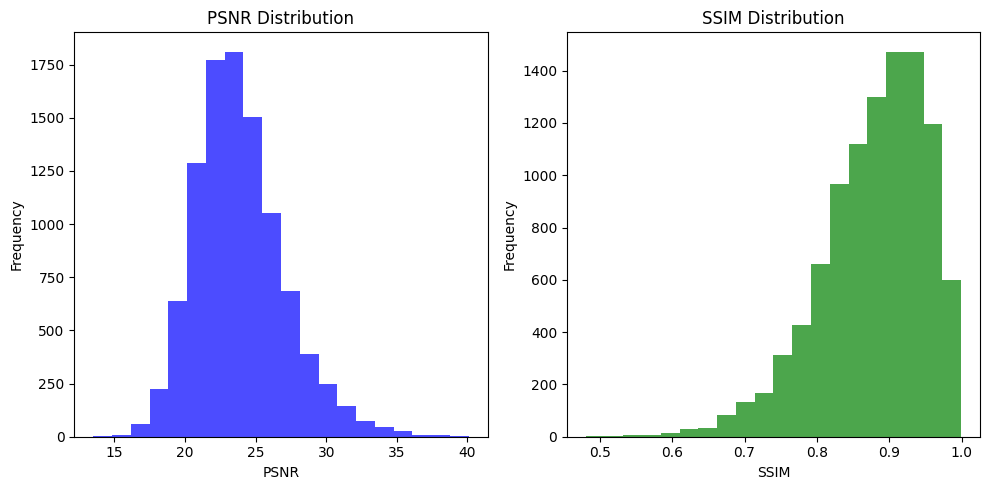

In [24]:
import torch
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt

# Paths for HR and LR test directories
test_lr_dir = "/content/cifar_super_resolution/test_lr"
test_hr_dir = "/content/cifar_super_resolution_resized/test_hr"

# Load model
model.eval()
model = model.to(device)

# Metric calculation
psnr_values = []
ssim_values = []

# Iterate over test set
test_lr_files = sorted(os.listdir(test_lr_dir))
test_hr_files = sorted(os.listdir(test_hr_dir))

for lr_file, hr_file in zip(test_lr_files, test_hr_files):
    # Load LR and HR images
    lr_image = np.load(os.path.join(test_lr_dir, lr_file))
    hr_image = np.load(os.path.join(test_hr_dir, hr_file))

    # Convert to PyTorch tensor
    lr_image = torch.tensor(lr_image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
    hr_image = torch.tensor(hr_image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

    # Super-resolve using the model
    with torch.no_grad():
        sr_image = model(lr_image)

    # Convert to numpy for metrics
    sr_image_np = sr_image.squeeze().cpu().permute(1, 2, 0).numpy()
    hr_image_np = hr_image.squeeze().cpu().permute(1, 2, 0).numpy()

    # Denormalize images to [0, 255]
    sr_image_np = ((sr_image_np + 1) / 2 * 255).clip(0, 255).astype(np.uint8)
    hr_image_np = ((hr_image_np + 1) / 2 * 255).clip(0, 255).astype(np.uint8)

    # Calculate metrics
    psnr_values.append(psnr(hr_image_np, sr_image_np, data_range=255))
    ssim_values.append(ssim(hr_image_np, sr_image_np, win_size=3, multichannel=True, data_range=255))  # win_size=3

# Average metrics
avg_psnr = np.mean(psnr_values)
avg_ssim = np.mean(ssim_values)

print(f"Average PSNR: {avg_psnr:.2f}")
print(f"Average SSIM: {avg_ssim:.4f}")

# Plot metric distributions
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(psnr_values, bins=20, color='blue', alpha=0.7)
plt.title("PSNR Distribution")
plt.xlabel("PSNR")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(ssim_values, bins=20, color='green', alpha=0.7)
plt.title("SSIM Distribution")
plt.xlabel("SSIM")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


**PSNR** measures the quality of the super-resolved image compared to the original high-resolution image. It captures the pixel-level difference between the two images in a logarithmic scale.

**SSIM** measures the perceptual similarity between the super-resolved and high-resolution images, focusing on structural and texture similarities.

**Strengths:** High SSIM values indicate that the model excels at maintaining structural integrity and perceptual quality, making the super-resolved images visually similar to the originals.

**Weaknesses:** The moderate PSNR suggests there is room for improvement in minimizing pixel-level errors, which could impact quantitative accuracy.


# TEST WITH A SINGLE IMAGE

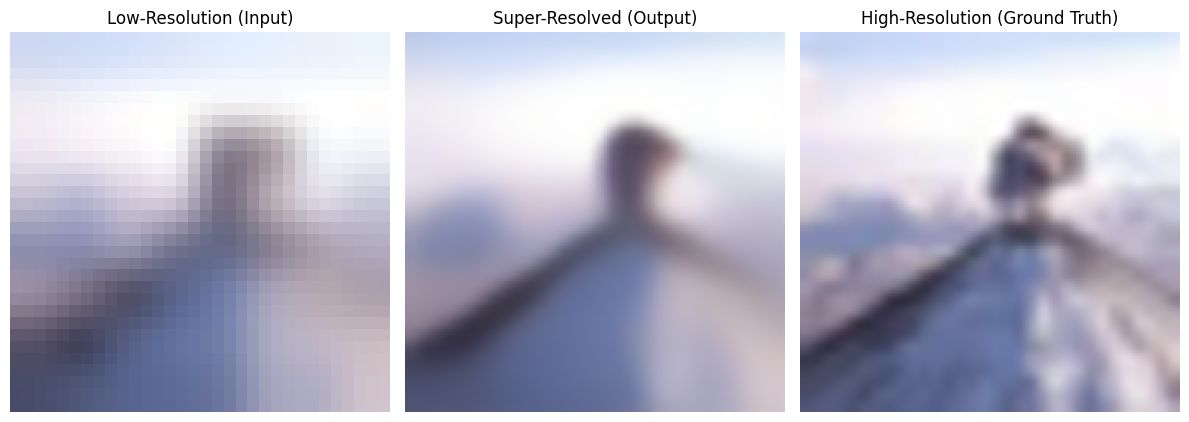

In [29]:
# Path to a test LR image
test_image_path = "/content/cifar_super_resolution/test_lr/img_00000_lr.npy"
ground_truth_path = "/content/cifar_super_resolution_resized/test_hr/img_00000_hr.npy"

# Load the test image and ground truth
lr_image = np.load(test_image_path)
hr_image = np.load(ground_truth_path)

# Convert to PyTorch tensor
lr_image_tensor = torch.tensor(lr_image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

# Generate super-resolved image
with torch.no_grad():
    sr_image_tensor = model(lr_image_tensor)

# Convert tensors to numpy
lr_image_np = ((lr_image + 1) / 2 * 255).astype(np.uint8)  # LR image
sr_image_np = ((sr_image_tensor.squeeze().cpu().permute(1, 2, 0).numpy() + 1) / 2 * 255).clip(0, 255).astype(np.uint8)  # SR image
hr_image_np = ((hr_image + 1) / 2 * 255).astype(np.uint8)  # HR ground truth

# Plot images
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(lr_image_np)
plt.title("Low-Resolution (Input)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(sr_image_np)
plt.title("Super-Resolved (Output)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(hr_image_np)
plt.title("High-Resolution (Ground Truth)")
plt.axis("off")

plt.tight_layout()
plt.show()


**Super-Resolved (Output)**: The model successfully upscaled the image, but the output still lacks sharpness and finer details. While the overall structure is preserved, textures appear smooth and blurry. This may suggest:

The model is prioritizing perceptual similarity but struggles with high-frequency details.
Possible limitations in the training data or a need for further tuning, such as adding adversarial loss or improving the perceptual loss weight.

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
from torchvision.transforms import functional as TF
import random

# Augmentation Function
def augment_data(lr_image, hr_image):
    if random.random() > 0.5:
        lr_image = TF.hflip(lr_image)
        hr_image = TF.hflip(hr_image)
    if random.random() > 0.5:
        lr_image = TF.vflip(lr_image)
        hr_image = TF.vflip(hr_image)
    if random.random() > 0.5:
        angle = random.uniform(-15, 15)
        lr_image = TF.rotate(lr_image, angle)
        hr_image = TF.rotate(hr_image, angle)
    return lr_image, hr_image

# Advanced Loss Functions
class GANLoss(nn.Module):
    def __init__(self, real_label=1.0, fake_label=0.0):
        super(GANLoss, self).__init__()
        self.real_label = real_label
        self.fake_label = fake_label
        self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, prediction, target_is_real):
        target = torch.full_like(prediction, self.real_label if target_is_real else self.fake_label, device=prediction.device)
        return self.criterion(prediction, target)

# Perceptual Loss
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg19(pretrained=True).features[:8].eval()
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg

    def forward(self, sr, hr):
        mean = torch.tensor([0.485, 0.456, 0.406]).to(sr.device).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).to(sr.device).view(1, 3, 1, 1)
        sr = (sr + 1) / 2
        hr = (hr + 1) / 2
        sr = (sr - mean) / std
        hr = (hr - mean) / std
        sr_features = self.vgg(sr)
        hr_features = self.vgg(hr)
        return nn.functional.l1_loss(sr_features, hr_features)

# Training Parameters
num_epochs = 10
learning_rate = 1e-5  # Reduced learning rate
batch_size = 8
patience = 5
validation_interval = 3
best_val_loss = float('inf')
epochs_without_improvement = 0

# Optimizer and Scheduler
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=3)

# Loss Functions
criterion_l1 = nn.L1Loss()
criterion_perceptual = PerceptualLoss().to(device)
criterion_gan = GANLoss().to(device)

# GradScaler for Mixed Precision
scaler = GradScaler()

# Initialize lists to store loss values for plotting
train_losses = []
val_losses = []

# Training Loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        lr_images = batch['lr_image'].to(device, memory_format=torch.channels_last)
        hr_images = batch['hr_image'].to(device, memory_format=torch.channels_last)

        # Data Augmentation
        lr_images, hr_images = augment_data(lr_images, hr_images)

        optimizer.zero_grad()

        with autocast():  # Mixed Precision
            sr_images = model(lr_images)
            loss_l1 = criterion_l1(sr_images, hr_images)
            loss_perceptual = criterion_perceptual(sr_images, hr_images)
            total_loss = 0.7 * loss_l1 + 0.2 * loss_perceptual

        # Backpropagation
        scaler.scale(total_loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        scaler.step(optimizer)
        scaler.update()

        running_loss += total_loss.item()

    # Calculate average training loss for this epoch
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}")

    # Validate every `validation_interval` epochs
    if (epoch + 1) % validation_interval == 0:
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                lr_images = batch['lr_image'].to(device, memory_format=torch.channels_last)
                hr_images = batch['hr_image'].to(device, memory_format=torch.channels_last)

                with autocast():
                    sr_images = model(lr_images)
                    loss_l1 = criterion_l1(sr_images, hr_images)
                    loss_perceptual = criterion_perceptual(sr_images, hr_images)
                    total_loss = 0.7 * loss_l1 + 0.2 * loss_perceptual

                val_loss += total_loss.item()

        # Calculate average validation loss for this epoch
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            best_model_path = f"/content/drive/My Drive/RealESRGAN_fine_tuned_epoch_{epoch+1}.pth"
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model at epoch {epoch+1} to {best_model_path}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Step the scheduler
    scheduler.step()

print("Fine-tuning complete.")

# Save losses for plotting later
import pickle
with open("/content/drive/My Drive/train_val_losses.pkl", "wb") as f:
    pickle.dump({"train_losses": train_losses, "val_losses": val_losses}, f)


<ipython-input-31-f7c4772f1e28>:74: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/10:   0%|          | 0/6250 [00:00<?, ?it/s]<ipython-input-31-f7c4772f1e28>:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed Precision
Epoch 1/10: 100%|██████████| 6250/6250 [20:11<00:00,  5.16it/s]


Epoch 1/10, Training Loss: 0.4440


Epoch 2/10: 100%|██████████| 6250/6250 [20:07<00:00,  5.18it/s]


Epoch 2/10, Training Loss: 0.4377


Epoch 3/10: 100%|██████████| 6250/6250 [20:06<00:00,  5.18it/s]

Epoch 3/10, Training Loss: 0.4355



<ipython-input-31-f7c4772f1e28>:123: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/10, Validation Loss: 0.4217
Saved best model at epoch 3 to /content/drive/My Drive/RealESRGAN_fine_tuned_epoch_3.pth


Epoch 4/10: 100%|██████████| 6250/6250 [20:01<00:00,  5.20it/s]


Epoch 4/10, Training Loss: 0.4347


Epoch 5/10: 100%|██████████| 6250/6250 [20:08<00:00,  5.17it/s]


Epoch 5/10, Training Loss: 0.4331


Epoch 6/10: 100%|██████████| 6250/6250 [20:02<00:00,  5.20it/s]

Epoch 6/10, Training Loss: 0.4323


Epoch 6/10, Validation Loss: 0.4209
Saved best model at epoch 6 to /content/drive/My Drive/RealESRGAN_fine_tuned_epoch_6.pth


Epoch 7/10: 100%|██████████| 6250/6250 [19:57<00:00,  5.22it/s]


Epoch 7/10, Training Loss: 0.4317


Epoch 8/10: 100%|██████████| 6250/6250 [20:03<00:00,  5.19it/s]


Epoch 8/10, Training Loss: 0.4308


Epoch 9/10: 100%|██████████| 6250/6250 [19:30<00:00,  5.34it/s]

Epoch 9/10, Training Loss: 0.4299


Epoch 9/10, Validation Loss: 0.4204
Saved best model at epoch 9 to /content/drive/My Drive/RealESRGAN_fine_tuned_epoch_9.pth


Epoch 10/10: 100%|██████████| 6250/6250 [19:57<00:00,  5.22it/s]

Epoch 10/10, Training Loss: 0.4297
Fine-tuning complete.


# EVALUATION FINAL MODEL

Evaluating the model...


Evaluating Test Data: 100%|██████████| 625/625 [01:32<00:00,  6.76it/s]

Average PSNR: 24.1044
Average SSIM: 0.8833


Sample results saved in /content/drive/My Drive/test_samples/


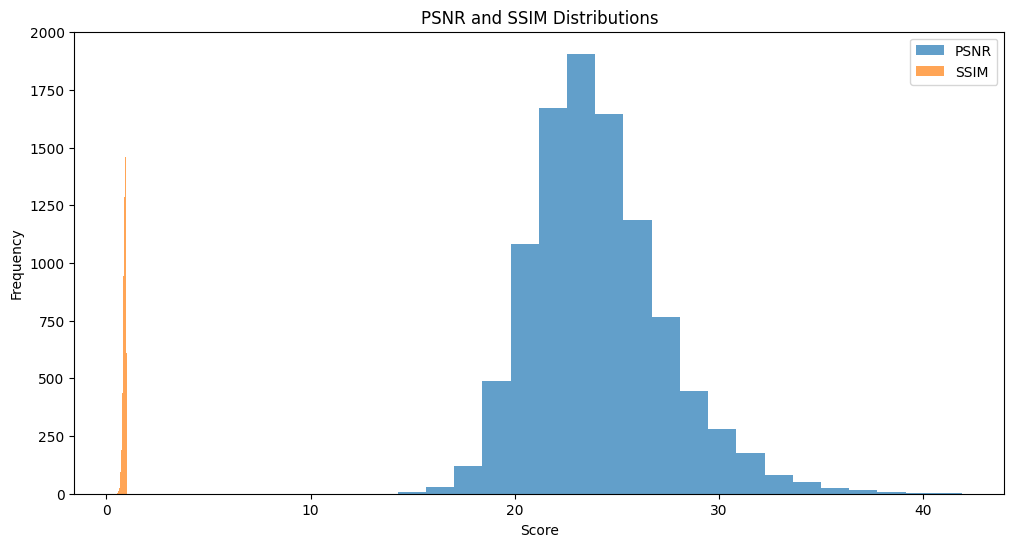

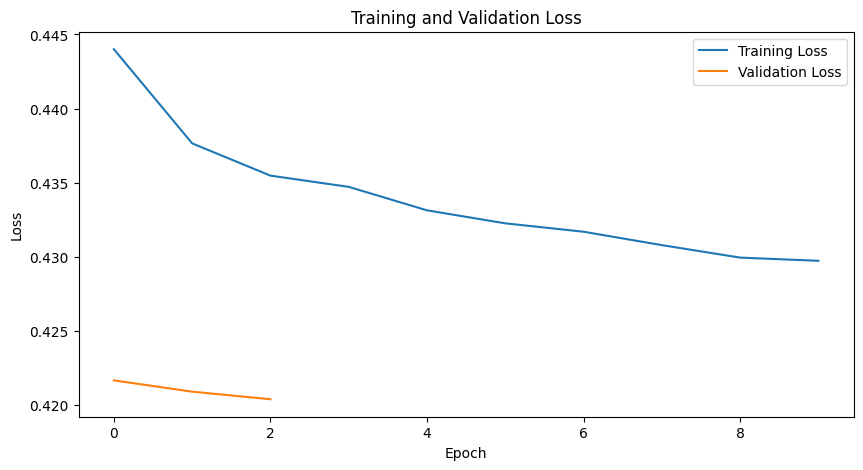

In [38]:
# Function to calculate PSNR
def calculate_psnr(hr, sr):
    hr = ((hr + 1) / 2).clamp(0, 1).cpu().numpy().transpose(1, 2, 0)
    sr = ((sr + 1) / 2).clamp(0, 1).cpu().numpy().transpose(1, 2, 0)
    return psnr(hr, sr, data_range=1.0)

# Function to calculate SSIM
def calculate_ssim(hr, sr):
    hr = ((hr + 1) / 2).clamp(0, 1).cpu().numpy().transpose(1, 2, 0)
    sr = ((sr + 1) / 2).clamp(0, 1).cpu().numpy().transpose(1, 2, 0)
    return ssim(hr, sr, win_size=3, multichannel=True, data_range=1.0)

# Paths
test_sample_dir = "/content/drive/My Drive/test_samples/"
os.makedirs(test_sample_dir, exist_ok=True)

# Lists to store PSNR and SSIM scores
psnr_values = []
ssim_values = []

# Evaluation
model.eval()
print("Evaluating the model...")

for batch in tqdm(test_loader, desc="Evaluating Test Data"):
    lr_images = batch['lr_image'].to(device, memory_format=torch.channels_last)
    hr_images = batch['hr_image'].to(device, memory_format=torch.channels_last)

    with torch.no_grad():
        sr_images = model(lr_images)

    for i in range(lr_images.size(0)):
        psnr_values.append(calculate_psnr(hr_images[i], sr_images[i]))
        # Append the returned SSIM value
        ssim_values.append(calculate_ssim(hr_images[i], sr_images[i]))

# Print overall results
print(f"Average PSNR: {np.mean(psnr_values):.4f}")
print(f"Average SSIM: {np.mean(ssim_values):.4f}")

# Save sample results and visualize
for i, batch in enumerate(test_loader):
    if i == 5:  # Limit to 5 batches for visualization
        break

    lr_images = batch['lr_image'].to(device, memory_format=torch.channels_last)
    hr_images = batch['hr_image'].to(device, memory_format=torch.channels_last)

    with torch.no_grad():
        sr_images = model(lr_images)

    for j in range(lr_images.size(0)):
        lr_image = ((lr_images[j].cpu() + 1) / 2).clamp(0, 1).permute(1, 2, 0).numpy()
        sr_image = ((sr_images[j].cpu() + 1) / 2).clamp(0, 1).permute(1, 2, 0).numpy()
        hr_image = ((hr_images[j].cpu() + 1) / 2).clamp(0, 1).permute(1, 2, 0).numpy()

        # Plot and save results
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(lr_image)
        axs[0].set_title("Low-Resolution")
        axs[1].imshow(sr_image)
        axs[1].set_title("Super-Resolved")
        axs[2].imshow(hr_image)
        axs[2].set_title("High-Resolution")
        for ax in axs:
            ax.axis('off')
        plt.tight_layout()

        # Save the figure
        image_save_path = os.path.join(test_sample_dir, f"result_{i}_{j}.png")
        plt.savefig(image_save_path)
        plt.close()

print(f"Sample results saved in {test_sample_dir}")

# Plot PSNR and SSIM distributions
plt.figure(figsize=(12, 6))
plt.hist(psnr_values, bins=20, alpha=0.7, label="PSNR")
plt.hist(ssim_values, bins=20, alpha=0.7, label="SSIM")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("PSNR and SSIM Distributions")
plt.legend()
plt.savefig("/content/drive/My Drive/metrics_distribution.png")
plt.show()

# Load and plot training/validation losses
with open("/content/drive/My Drive/train_val_losses.pkl", "rb") as f:
    losses = pickle.load(f)

train_losses = losses['train_losses']
val_losses = losses['val_losses']

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig("/content/drive/My Drive/loss_plot.png")
plt.show()

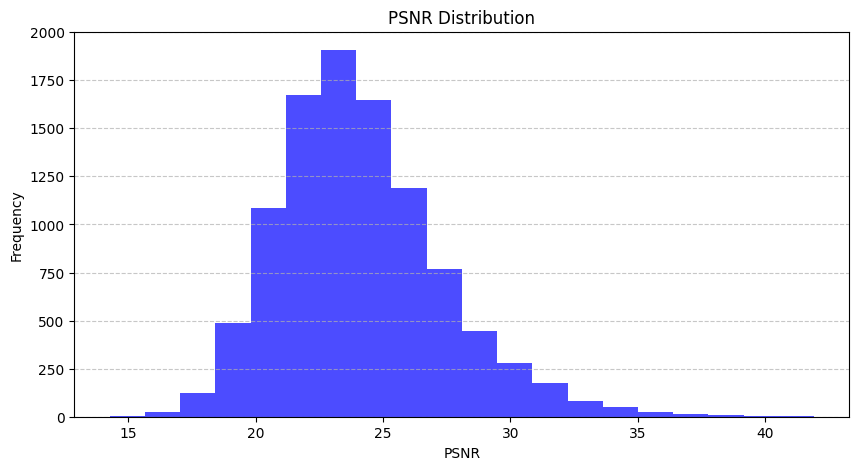

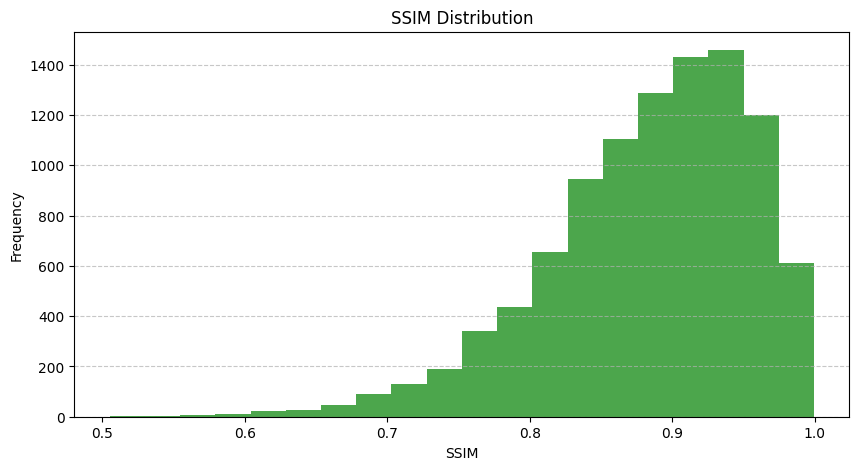

In [39]:
import matplotlib.pyplot as plt

# Plot PSNR distribution
plt.figure(figsize=(10, 5))
plt.hist(psnr_values, bins=20, color='blue', alpha=0.7)
plt.title("PSNR Distribution")
plt.xlabel("PSNR")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot SSIM distribution
plt.figure(figsize=(10, 5))
plt.hist(ssim_values, bins=20, color='green', alpha=0.7)
plt.title("SSIM Distribution")
plt.xlabel("SSIM")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


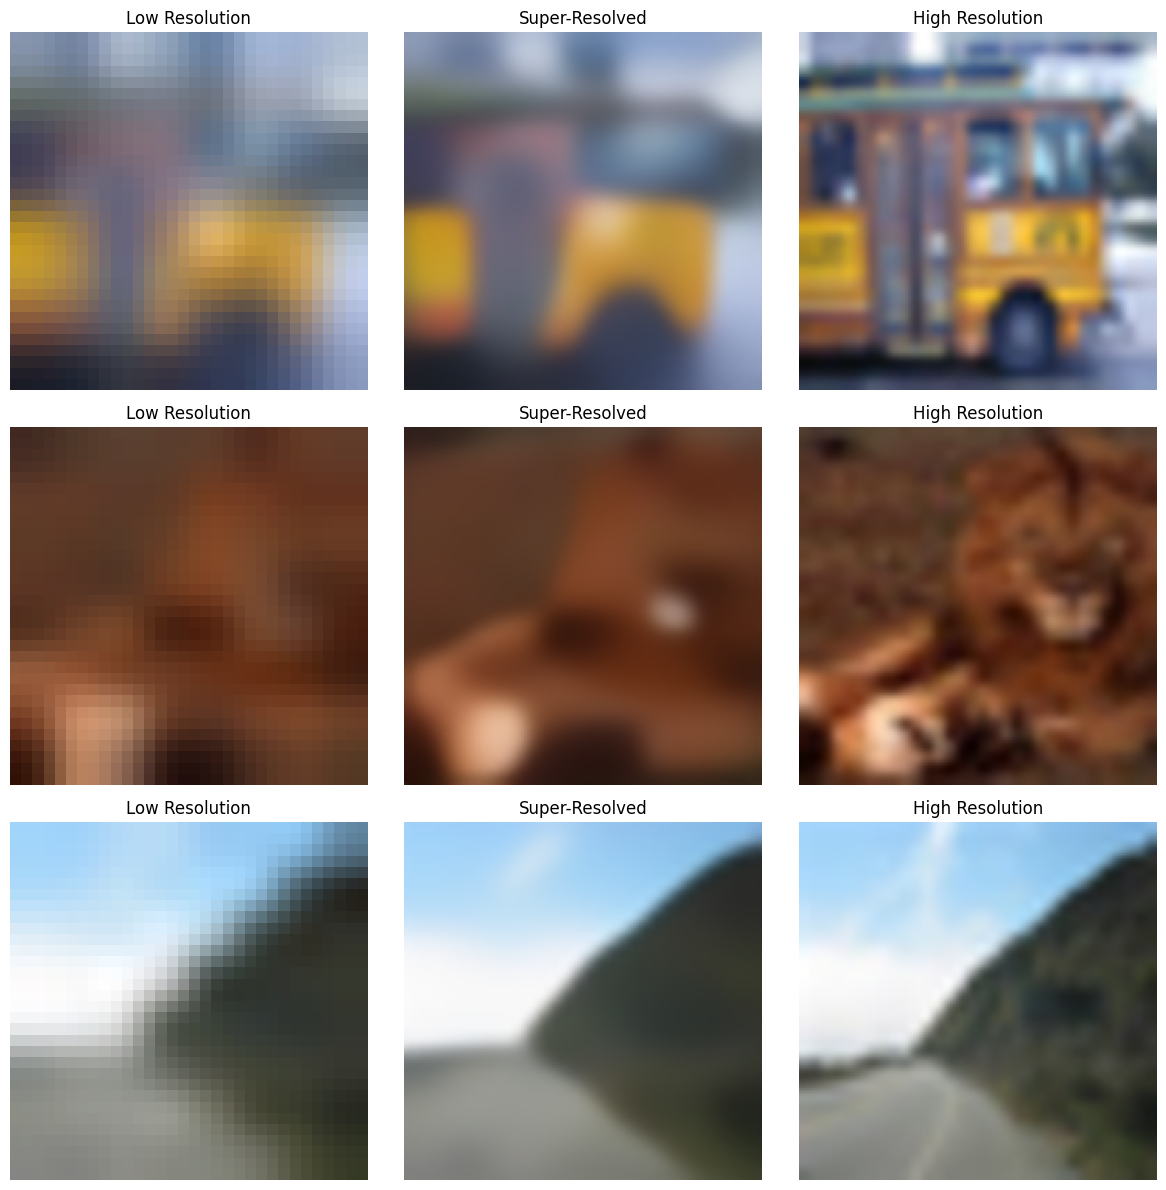

In [40]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Function to denormalize and convert tensor to image
def tensor_to_image(tensor):
    image = tensor.squeeze().cpu().permute(1, 2, 0).numpy()  # Convert to HWC
    image = ((image + 1) / 2 * 255).clip(0, 255).astype(np.uint8)  # Denormalize and convert to [0, 255]
    return Image.fromarray(image)

# Test model on 3 images
test_lr_dir = "/content/cifar_super_resolution/test_lr"
test_hr_dir = "/content/cifar_super_resolution_resized/test_hr"

# Select 3 random test images
test_lr_files = sorted(os.listdir(test_lr_dir))
test_hr_files = sorted(os.listdir(test_hr_dir))
sample_indices = np.random.choice(len(test_lr_files), 3, replace=False)

# Iterate over selected indices and visualize
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

for i, idx in enumerate(sample_indices):
    # Load LR and HR images
    lr_image_path = os.path.join(test_lr_dir, test_lr_files[idx])
    hr_image_path = os.path.join(test_hr_dir, test_hr_files[idx])

    lr_image = np.load(lr_image_path)
    hr_image = np.load(hr_image_path)

    # Convert LR image to tensor
    lr_tensor = torch.tensor(lr_image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

    # Pass through model
    model.eval()
    with torch.no_grad():
        sr_tensor = model(lr_tensor)

    # Convert tensors to images
    lr_img = tensor_to_image(lr_tensor)
    sr_img = tensor_to_image(sr_tensor)
    hr_img = tensor_to_image(torch.tensor(hr_image, dtype=torch.float32).permute(2, 0, 1))

    # Plot results
    axs[i, 0].imshow(lr_img)
    axs[i, 0].set_title("Low Resolution")
    axs[i, 0].axis("off")

    axs[i, 1].imshow(sr_img)
    axs[i, 1].set_title("Super-Resolved")
    axs[i, 1].axis("off")

    axs[i, 2].imshow(hr_img)
    axs[i, 2].set_title("High Resolution")
    axs[i, 2].axis("off")

plt.tight_layout()
plt.show()
